In [199]:
import numpy as np   
from matplotlib import pyplot as plt   
from matplotlib import animation 
import pandas as pd
import os
from pandas import Series,DataFrame  
import matplotlib.animation as animation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
%matplotlib inline

In [200]:
### some funcs
def genTimeSeq(span=10):
    first = df['time'][0]
    last = df['time'][len(df.time)-1]
    delta = timedelta(minutes=span)
    time = first
    times = [time]
    while times[-1] < last: ## 5min 共818个时间段  10min 共410个时间段
        time += delta
        times.append(time)
    return times

## generate time segment label for the df
def genTimeSeg(time,idx):
    if idx == timeLen-1: return timeLen-1
    if time>= timeSeq[idx] and time<timeSeq[idx+1]:
        return idx
    else:
        return genTimeSeg(time,idx+1)

## generate segIdx given segNum    
def genSegIdx(segNum,seg):
    return [i for i,s in enumerate(seg) if s==segNum]

# Compute DBSCAN
def dbscan(data,eps=0.3,min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    clu_num = Series(db.labels_).value_counts()
    core_samples = np.zeros_like(db.labels_,dtype=bool)
    core_samples[db.core_sample_indices_] = True
    return db,clu_num,core_samples

## plot funcs
def clusterPlot(labels,data,core_samples,axis,markersize=[10,4],alpha=0.7,size=[10,7],cex=[80,20]):
    # Black removed and is used for noise instead.
    # core_samples is a bool list
    unique_labels = set(labels)
    n_clusters_ = len(unique_labels) - 1 if -1 in labels else 0
    fig, ax = plt.subplots(figsize=size)

    s = np.where(core_samples,cex[0],cex[1]) ## 核心点大小为14，非核心点为10
    colors = np.array(['MediumSlateBlue','DarkSeaGreen','Gold','IndianRed','Pink','Aquamarine','Cyan','Black'])
    c = colors[db.labels_]

    if axis is not None:
        ax.axis(axis)
    ax.scatter(data[:, 0], data[:, 1],alpha=alpha,c=c,s=s)
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
def pointPlot(data,axis,size=[10,7]):
    fig, ax = plt.subplots(figsize=size)
    ax.scatter(data[:,0],data[:,1])
    ax.axis(axis)
    plt.show()

In [201]:
os.chdir(r"C:\Users\Administrator\desktop\StormCloud")
df = pd.read_csv('nanrui_root.csv',header=None,names=['time','lat','long','cur'])

## process time
from datetime import datetime,timedelta
format = '%Y/%m/%d %H:%M'
df['time'] = df[['time']].applymap(lambda x:datetime.strptime(x,format))
df['strength'] = np.abs(df.cur)

timeSeq = genTimeSeq(10) # gen time seq to seperate time col
timeLen = len(timeSeq)
print(timeLen)
timeSeg = Series([genTimeSeg(t,0) for t in df.time]) # reflect time to different tag 

## range of long and lat 
xlim = [df['long'].min(),df['long'].max()]
ylim = [df['lat'].min(),df['lat'].max()]
minL, maxL = df['strength'].min(),df['strength'].max()

# ax = df.loc[seg==0,:].plot(kind='scatter',y='lat',x='long',c='strength',xlim=xlim,ylim=ylim)
# plt.show()

410


In [217]:
class AnimatedScatterCluster(object):
    
    def __init__(self,df,seg,time,interval,eps=0.05,min_samples=5):
        self.df = np.array(df)
        self.seg = seg
        self.time = time
        self.nframe = len(time)-1
#         self.fig, self.ax = plt.subplots()
        self.interval = interval 
        self.df_tran = StandardScaler().fit_transform(self.df) ## return array
        self.eps = eps
        self.min_samples = min_samples
#         self.colors = colors
#         self.fig = plt.figure()
#         self.ax = plt.gca()
        self.fig,self.ax = plt.subplots()
        self.initI = int(seg.head(1))
        self.clusterN = {}
        self.clusterData = {}
        self.clusterLable = {}
        self.centerPoint = {} # to store center point xy if cluster=0 (-1,-1)
        self.ani = animation.FuncAnimation(self.fig, self.update, interval = self.interval,
                                           init_func=self.setup_plot,frames=self.nframe,blit=True,repeat=False)
        
    def setup_plot(self):
        self.text = self.ax.text(xlim[0]+0.3,ylim[1]-0.3,"")
        self.scat = self.ax.scatter([],[], c=[],s=20, animated=True,alpha=0.9)
        self.ax.axis(xlim+ylim)
        self.scat.set_clim(minL,maxL)
#         plt.colorbar(self.scat)
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,self.text
    
    def update(self, i):
        ii = i + self.initI
        idx = genSegIdx(ii,self.seg)  ## timeSeg may not start from 0 
        ll = len(idx)
        if(len(idx) <= self.min_samples):
            text = str(ii)+": "+str(self.time[i])+"  cluster: 0"
            self.text = self.ax.text(xlim[0]+0.1,ylim[1]-0.1,text)
            data = self.df[idx]
            self.scat.set_offsets(data)
            self.scat.set_clim(0,100)
            c = np.array([0]*ll)
            s = np.array([10]*ll)
            self.scat.set_array(c)
            self.scat._sizes = s
            ## updata self data
            self.clusterN[ii] = 0
            self.clusterLable[ii] = [-1]*ll
            self.clusterData[ii] = data
            self.centerPoint[ii] = {-2:[-1,-1,ll]}
            
            
            # Set colors..
            return self.scat,self.text
        else:
            data = self.df[idx]
            data0 = self.df_tran[idx]
            db,clu_num,core_samples = dbscan(data0,eps=self.eps,min_samples=self.min_samples)
            labels = db.labels_
            n_clusters_ = len(set(labels)) - 1 if -1 in labels else 0
            text = str(ii)+": "+str(self.time[i])+"  cluster: "+str(n_clusters_)
            colors = list(np.linspace(0,100,n_clusters_+2))
            colors = np.array(colors[2:]+[0])
            self.text = self.ax.text(xlim[0]+0.1,ylim[1]-0.1,text)
            s = np.where(core_samples,50,10) ## 核心点大小为14，非核心点为10
            c = np.array(colors[labels])
            # Set x and y data...
            self.scat.set_offsets(data[:,:])
            # Set sizes...
            self.scat._sizes = s
            # Set colors..
            self.scat.set_array(c)
            self.scat.set_clim(0,100)
            ## update self data 
            self.clusterN[ii] = n_clusters_
            self.clusterLable[ii] = labels
            self.clusterData[ii] = data
            if n_clusters_ >= 1 :
                self.centerPoint[ii] = self._calCenterPoint(labels,data) 
            else:
                self.centerPoint[ii] = {-2:[-1,-1,ll]} 
            return self.scat,self.text
    
    def show(self):
        plt.show()
        
    def _calCenterPoint(self,labels,data):
        res = {} #{label:[x,y]}
        data = pd.DataFrame(data)
        grouped = data.groupby(labels)
        xy = grouped.apply(lambda x:np.mean(x,axis=0))
        n = grouped.size()
        for i in xy.index:
            res[i] = list(xy.loc[i,:])
            res[i].append(n[i])
        return res
    
    def _genXYCS(self):
        xy = np.empty((1,2))
        c = [] # color
        s = [] # size
        res = self.centerPoint
        for i,(k,v) in enumerate(res.items()): ## no cluster k=-2
            ll = len(v)
            if (ll>1):
                temp = np.vstack(v.values())
        #         if(xy): 
        #             xy = temp[:,0:2] 
        #         else: 
                xy = np.vstack((xy,temp[:,0:2]))
                c += [i]*ll
                s = np.hstack((s,temp[:,2]))
        xy = xy[1:,:]
        return xy,c,s
    
        
    def centerSeqPlot(self,axis,figsize=[20,15]):
        fig, ax = plt.subplots(figsize = figsize)
        xy,c,s = self._genXYCS()
        ax.scatter(xy[:,0],xy[:,1],c=c,s=s)
        ax.axis(axis)
        ax.grid(True)
        plt.show()

        
# if __name__ == '__main__':
#     %matplotlib qt
#     colors = np.array(list(range(1,20)))
#     #     colors = np.array(['MediumSlateBlue','DarkSeaGreen','Gold','IndianRed','Pink','Aquamarine','Cyan','Black'])
#     df0 = df[['long','lat']]
#     a = AnimatedScatterCluster(df0,timeSeg,timeSeq,interval = 500)
#     a.show()
#     mywriter = animation.FFMpegWriter()
#     a.ani.save('storm1.mp4',writer=mywriter)

In [218]:
## how many points each segment contains 
# Series(timeSeg).value_counts()[:20]

In [219]:
# timeSeg.value_counts()

In [220]:
%matplotlib inline
df0 = df[['long','lat']]
## consider 40-70
staN = 47
endN = 55 # 71
sta = genSegIdx(staN,timeSeg)[0]
end = genSegIdx(endN,timeSeg)[-1]
data0 = np.array(df0.iloc[sta:end+1,:])
# pointPlot(data0,axis=xlim+ylim)
# timeSeg[sta:end].value_counts() # point numbers in each time segment
df00 = df0.iloc[sta:end+1,:]
timeSeq00 = timeSeq[staN:endN+1] 
timeSeg00 = timeSeg[sta:end+1]
colors = np.array(list(range(1,20)))

In [286]:
# # 1km 差不多是0.01经纬度
# %matplotlib qt
# # 10min data: eps=0.1,min_samples=50 
# a49_55 = AnimatedScatterCluster(df00,timeSeg00,timeSeq00,interval = 1000,eps=0.2,min_samples=80)
# a49_55.show()
# # mywriter = animation.FFMpegWriter()
# # a.ani.save('storm_min_sample20.mp4',writer=mywriter)

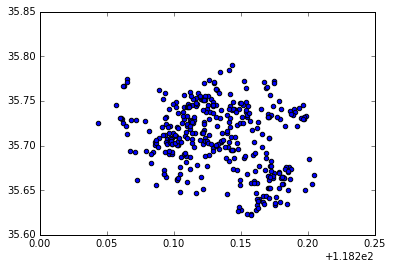

In [10]:
%matplotlib inline
fig,ax = plt.subplots()
ax.scatter(data[:,0],data[:,1])

## 椭圆作图

In [63]:
os.chdir(r"F:\gitInStormor\thunderstorm\data")
center = pd.read_csv('center.csv')
clusterData = pd.read_csv("clusterData.csv")
ellipse = pd.read_csv("ellipse.csv")
center.columns = ['x0','y0','size','cluID','frameID']
ellipse.columns = ['x0','y0','a','b','phi','cluID','frameID']

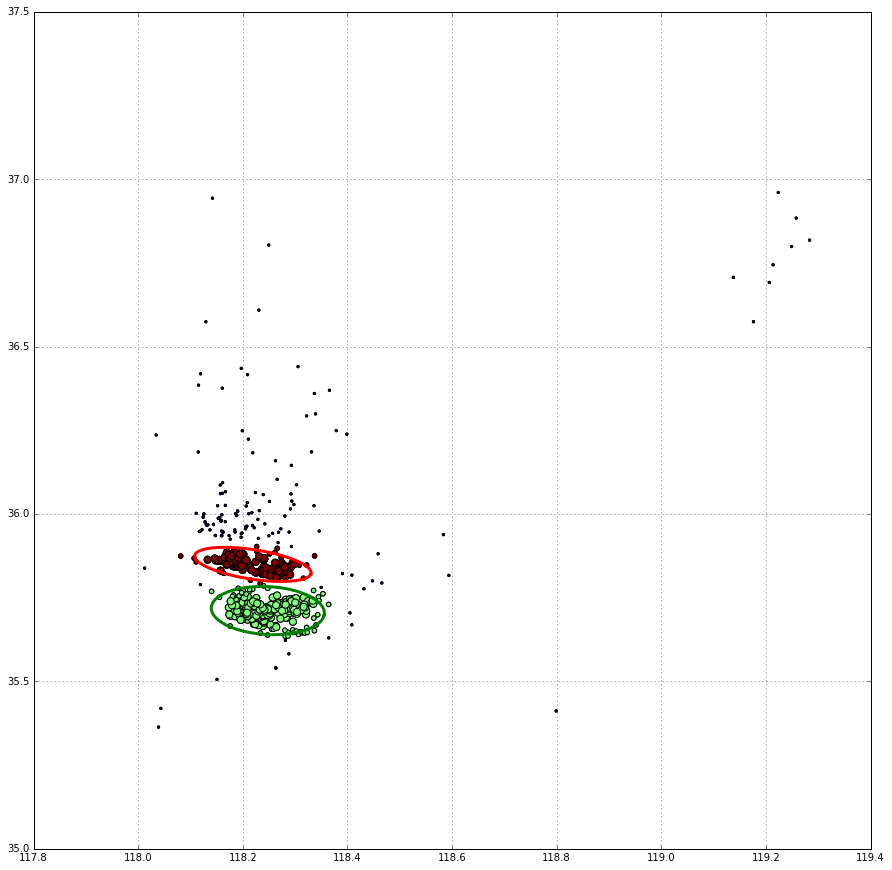

In [78]:
%matplotlib inline
Id = 48
cen = center.loc[center.frameID==Id,:]
ell = ellipse.loc[ellipse.frameID==Id,:]
clu = clusterData.loc[clusterData.frameID==Id,:]
psize1 = np.where(clu.cluID!=-1,20,5)
psize2 = np.where(clu.if_core,30,0)
psize = psize1+psize2
# clu.plot(x='x',y='y',kind='scatter',c=clu.cluID,size=pSize,figsize=[15,10])
fig,ax = plt.subplots(figsize=[15,15])
ax.scatter(clu.x,clu.y,s=psize,c=clu.cluID)
plot_ellipse(*ell.iloc[0,0:5],c='g',linestyle='-',linewidth=3)
plot_ellipse(*ell.iloc[1,0:5],c='r',linestyle='-',linewidth=3)
ax.grid(True)

In [15]:
def fit_ellipse(data): # data is m*2 format
    covariance = np.cov(data.T)
    eigval, eigvec = np.linalg.eig(covariance)
    minIdx, maxIdx = (0,1) if(eigval[0]<eigval[1]) else (1,0)
    minVal, maxVal = eigval[minIdx],eigval[maxIdx]
    minVec, maxVec = eigvec[:,minIdx],eigvec[:,maxIdx]
    angle = np.arctan2(maxVec[1],maxVec[0])
    angle = angle+2*np.pi if(angle<0) else angle
    x0,y0 = np.mean(data,axis=0)
    chisquare_val = 2.4477
    a = chisquare_val*np.sqrt(maxVal)
    b = chisquare_val*np.sqrt(minVal)
    phi = angle
    return x0,y0,a,b,phi

In [16]:
df = DataFrame(np.random.randn(20,2))
label = [2]*10+[1]*10
res = df.groupby(label).apply(lambda x:fit_ellipse(x))
# a = fit_ellipse(np.array(df))
# a
for i in res.index:
    print res[i]


(0.22557097528473169, 0.12465711481572359, 3.2202100410128143, 2.2164007806960107, 4.5768783421841404)
(0.19625398837909841, -0.14726206881064091, 2.4497558209278205, 1.7770691062922408, 5.7185789694272646)


In [58]:
def plot_ellipse(x0,y0,a,b,phi,**kargs):
    theta_grid = np.linspace(0,2*np.pi) #num=50
    ellipse_x_r = a*np.cos(theta_grid)
    ellipse_y_r = b*np.sin(theta_grid)
    R = np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    r_ellipse = np.dot(np.array([ellipse_x_r,ellipse_y_r]).T,R)
#     fig,ax = plt.subplots()
    ax.plot(r_ellipse[:,0]+x0,r_ellipse[:,1]+y0,**kargs)    

In [19]:
def area_ellipse(a,b):
    return np.pi*a*b

In [83]:
def containInEllipse(x,y,x0,y0,a,b,phi):
    # x,y can be either np.array or scalar
    ox = x - x0
    oy = y - y0
    rotx = ox * np.cos(phi) + oy * np.sin(phi)
    roty = -ox * np.sin(phi) + oy * np.cos(phi)
    dist_x = rotx / a
    dist_y = roty / b
    return (np.hypot(dist_x,dist_y)<=1)

## tracks 作图

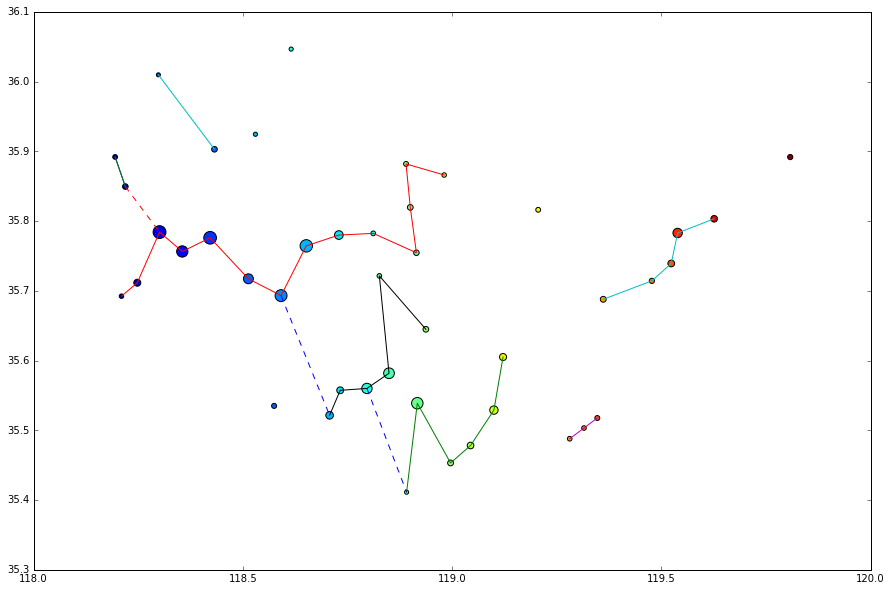

In [262]:
%matplotlib inline
dir = r"F:\gitInStormor\thunderstorm\data"
os.chdir(dir)
tracks = pd.read_csv("tracks.csv")
grouped = tracks.groupby(tracks.trackID)
c = tracks.frameID - min(tracks.frameID)
s = tracks['size']
fig,ax = plt.subplots(figsize=[15,10])
ax.scatter(tracks.x,tracks.y,c=c,s=s*2)
grouped = tracks.groupby(tracks.trackID)
grouped.apply(lambda x:ax.plot(x.x,x.y))
import hickle
MP = hickle.load('mergeCell.hkl')
SP = hickle.load('splitCell.hkl')
# fig,ax = plt.subplots(figsize=[15,10])
for i in MP:
    ax.plot(i[0],i[1],'r--')
for i in SP:
    ax.plot(i[0],i[1],'b--')

In [263]:
cluData = pd.read_csv("clusterData.csv") ## 52~60期间的点数最多
center = pd.read_csv("center.csv")
ellipse = pd.read_csv("ellipse.csv")
data = cluData.loc[cluData.frameID==58,:]
tracks.head()

,x,y,size,a,b,phi,cluID,frameID,trackID,f_x,f_y,f_size,f_a,f_b
0,118.194862,35.891899,11.256002,0.086307,0.041514,0.294817,0,47,0,118.194862,35.891899,11.256002,0.086307,0.041514
1,118.219269,35.849457,15.599968,0.114554,0.043347,6.026778,1,48,0,118.216827,35.853703,15.165571,0.112948,0.042739
2,118.210083,35.692295,9.945620,0.072699,0.043547,6.030888,1,47,1,118.210083,35.692295,9.945620,0.072699,0.043547
3,118.247795,35.711544,24.340126,0.108575,0.071358,6.165146,0,48,1,118.244026,35.709618,22.900675,0.105316,0.069216
4,118.300995,35.784157,82.515526,0.237295,0.110687,5.215055,0,49,1,118.346573,35.843788,130.207413,0.298084,0.139043


In [282]:
def plot_ellipse(x0,y0,a,b,phi,figNew=False,ax=None,**kargs): # if figNew=False,should specify ax
    theta_grid = np.linspace(0,2*np.pi) #num=50
    ellipse_x_r = a*np.cos(theta_grid)
    ellipse_y_r = b*np.sin(theta_grid)
    R = np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    r_ellipse = np.dot(np.array([ellipse_x_r,ellipse_y_r]).T,R)
    if figNew:
        fig,ax = plt.subplots()
        ax.plot(r_ellipse[:,0]+x0,r_ellipse[:,1]+y0,**kargs)
    else:
        ax.plot(r_ellipse[:,0]+x0,r_ellipse[:,1]+y0,**kargs)

def plotEllipseOnCluster(ellipse,clusterData,minFID,maxFID,figsize=[15,15],preEll=False,title=None,**kargs): ## center,ellipse,clusterData are DFs
    ell = ellipse if preEll else ellipse.loc[(ellipse.frameID>=minFID)&(ellipse.frameID<=maxFID),:]
    clu = clusterData.loc[(clusterData.frameID>=minFID)&(clusterData.frameID<=maxFID),:]
    xlim = [np.floor(clu.x.min()),np.ceil(clu.x.max())]
    ylim = [np.floor(clu.y.min()),np.ceil(clu.y.max())]
    minN,maxN = np.min(ell.frameID),np.max(ell.frameID)
    psize1 = np.where(clu.cluID!=-1,20,5)
    psize2 = np.where(clu.if_core,30,0)
    psize = psize1+psize2
    # clu.plot(x='x',y='y',kind='scatter',c=clu.cluID,size=pSize,figsize=[15,10])
    fig,ax = plt.subplots(figsize=figsize)
    ax.scatter(clu.x,clu.y,s=psize,c=clu.cluID)
    ellN = len(ell)
    for i in range(ellN):
        if ell.iloc[i,0]!=-1:
            plot_ellipse(*ell.iloc[i,0:5],ax=ax,**kargs)
    ax.grid(True)
    title = "FrameID: "+str(minN)+"~"+str(maxN) if title is None else title
    ax.set_title(title)                                           
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[1],ylim[1])
    ax.set_xticks(np.arange(xlim[0],xlim[1],0.5))                                                       
    ax.set_xticks(np.arange(xlim[0],xlim[1],0.1), minor=True)                                           
    ax.set_yticks(np.arange(ylim[0],ylim[1],0.5))                                                       
    ax.set_yticks(np.arange(ylim[0],ylim[1],0.1), minor=True)                                           

    # and a corresponding grid                                                       

    ax.grid(which='both')   
    plt.show()


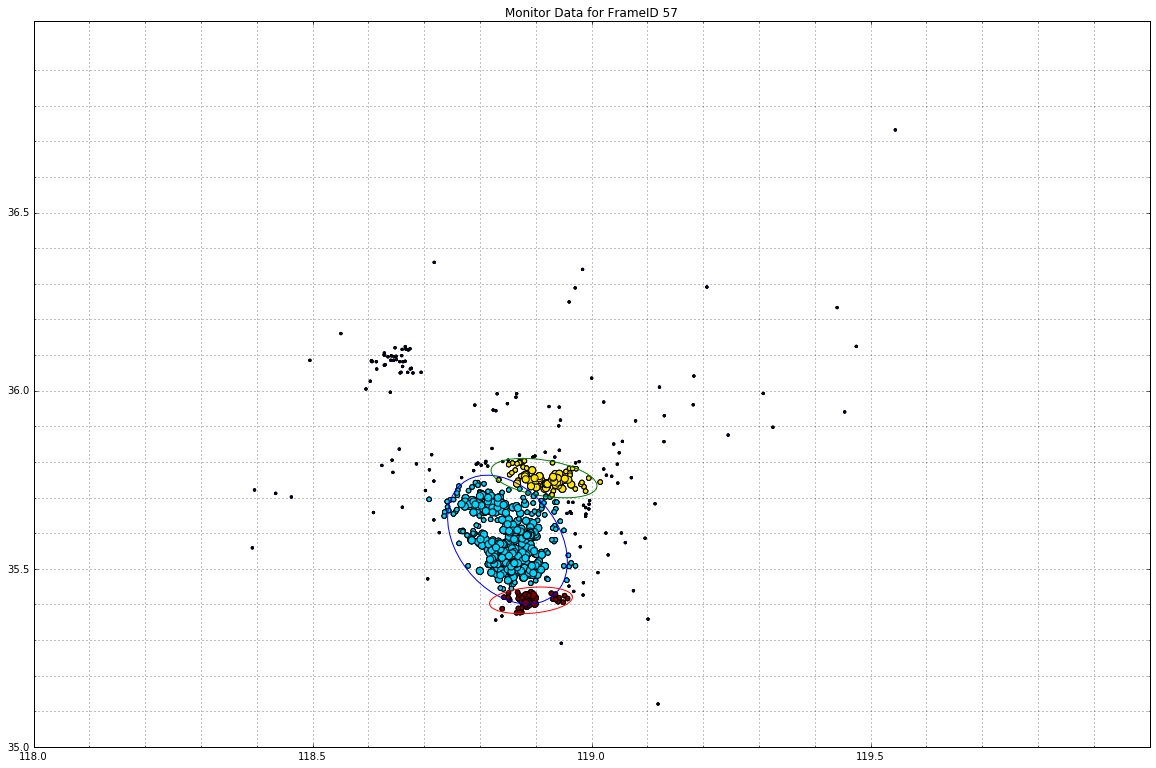

In [291]:
plotEllipseOnCluster(ellipse,cluData,57,57,figsize=[20,13],title="Monitor Data for FrameID 57")

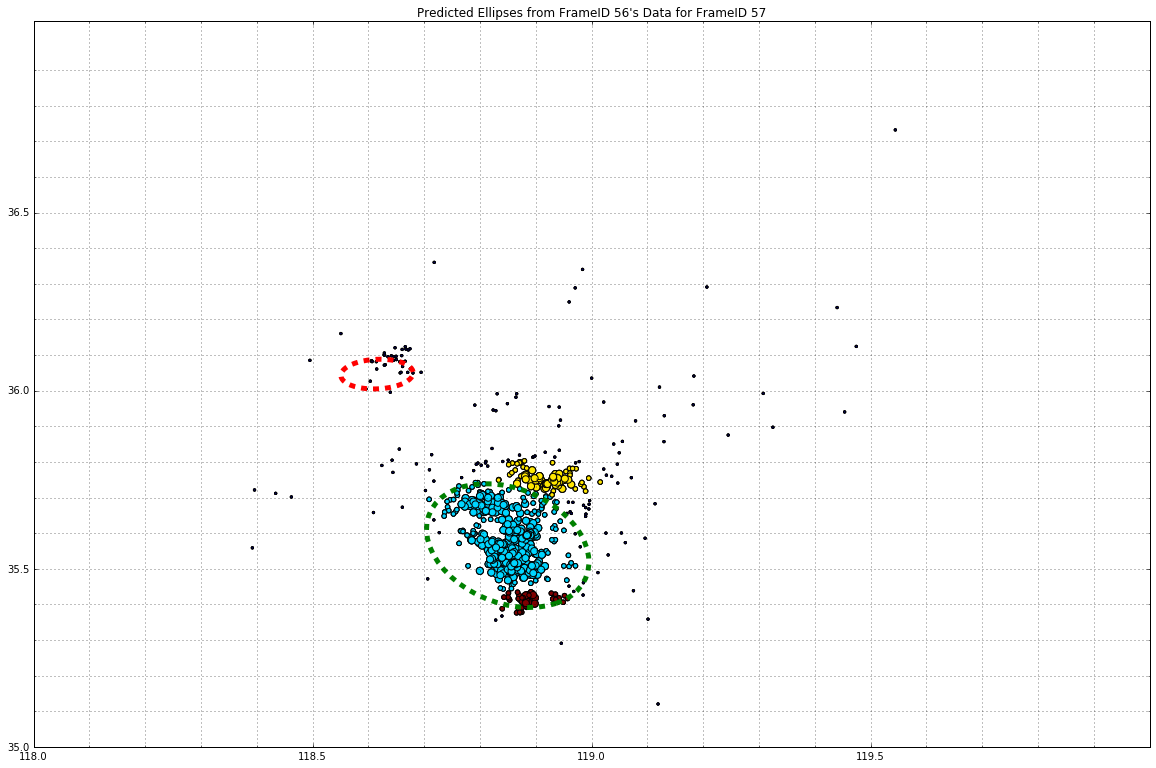

In [292]:
f_ell = tracks.loc[tracks.frameID==56,['f_x','f_y','f_a','f_b','phi','frameID']]
plotEllipseOnCluster(f_ell,cluData,57,57,figsize=[20,13],preEll=True,linestyle="--",linewidth=5,title="Predicted Ellipses from FrameID 56's Data for FrameID 57")

## 评估预测效果

In [ ]:
preXlim = 
preYlim = 
realXlim = 
realYlim = 

In [ ]:
class AnimatedScatterCluster(AnimatedScatter):
    
    def __init__(self,df,seg,timeLen,time,colors,interval,eps=0.05,min_samples=5):
#         super().__init__(df,seg,timeLen,time,interval)
        self.df = np.array(df)
        self.df0 = StandardScaler().fit_transform(self.df) ## return array
        self.eps = eps
        self.min_samples = min_samples
        self.colors = colors
        self.fig = plt.figure()
        self.ax = plt.gca()
        self.ani = animation.FuncAnimation(self.fig, self.update, interval = self.interval,
                                           init_func=self.setup_plot,frames=self.nframe,blit=True,repeat=False)
    
    def update(self, i):
        """Update the scatter plot."""
        data = self.df[genSegIdx(i,timeSeg)]
        print(data)
        data0 = self.df0[genSegIdx(i,timeSeg)]
        db,clu_num,core_samples = dbscan(data,eps=self.eps,min_samples=self.min_samples)
        n_clusters_ = len(set(labels)) - 1 if -1 in labels else 0
        text = str(i)+": "+str(self.time[i])+"  cluster: "+str(n_clusters_)
        self.text = self.ax.text(xlim[0]+0.1,ylim[1]-0.1,text)
        s = np.where(core_samples,cex[0],cex[1]) ## 核心点大小为14，非核心点为10
        c = colors[db.labels_]
        
        # Set x and y data...
        self.scat.set_offsets(data[:,:])
        # Set sizes...
        self.scat._sizes = c
        # Set colors..
        self.scat.set_array(s)
        return self.scat,self.text
    # need to return the updated artist for FuncAnimation to draw..
    # Note that it expects a sequence of artists, thus the trailing comma.
        
    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        self.text = self.ax.text(xlim[0]+0.3,ylim[1]-0.3," ")
        self.scat = self.ax.scatter([], [], c=[],s=[], animated=True,edgecolors='none',alpha=0.9)
        self.ax.axis(xlim+ylim)
        self.scat.set_clim(minL,maxL)
#         plt.colorbar(self.scat)
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,self.text

if __name__ == '__main__':
    %matplotlib qt
    colors = np.array(['MediumSlateBlue','DarkSeaGreen','Gold','IndianRed','Pink','Aquamarine','Cyan','Black'])
    df0 = df[['long','lat']]
    a = AnimatedScatterCluster(df0,timeSeg,timeLen,timeSeq,colors,interval = 200)
    a.show()
    
    #df,seg,timesLen,time,colors,interval,eps=0.05,min_samples=5):